# JSON Transformers
I want to make a transformer that can predict json data in linear relationships.

I plan on doing this by making a large dict with a few simple relatonships.


## Install and Library Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%%bash
pip install torchviz -q
pip install polars -q
pip install black[jupyter] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
!black '/content/drive/MyDrive/Colab Notebooks/Transformers/'
!isort '/content/drive/MyDrive/Colab Notebooks/Transformers/'

All done! ✨ 🍰 ✨
2 files left unchanged.
/bin/bash: isort: command not found


In [ ]:
from torchviz import make_dot
import re
from typing import List
import polars
import numpy as np
import torch
from torch import nn
from tqdm.notebook import trange
import numpy as np
import torch
from torch import nn
from tqdm.notebook import trange
import polars as pl
import requests
from io import StringIO

## Read Data


In [ ]:
energy = pl.read_parquet(
    "/content/drive/MyDrive/Colab Notebooks/Transformers/energy/ab_energy.parquet",
)
weather = pl.read_parquet(
    "/content/drive/MyDrive/Colab Notebooks/Transformers/energy/ab_weather.parquet",
)

In [ ]:
energy.head()

Date_Begin_GMT,Date_Begin_Local,AFG1,AKE1,ALP1,ALP2,APS1,BCR2,BCRK,BIG,BOW1,BR3,BR4,BR5,BRA,BTR1,CAL1,CHIN,CMH1,CNR5,CR1,CRS1,CRS2,CRS3,CRW1,DAI1,DKSN,DOWG,DRW1,DV1,EAGL,EC01,EC04,ENC1,ENC2,ENC3,FNG1,...,SET1,WEF1,WRW1,HYS1,JER1,WHT2,ERV2,HRT1,RTL1,TVS1,NPC3,STR1,STR2,BRK1,BRK2,COL1,NMK1,MON1,CRD1,CRD2,WHE1,KKP1,KKP2,FMG1,ERV3,SRL1,EPS1,HHW1,ACTUAL_POOL_PRICE,ACTUAL_AIL,DAY_AHEAD_POOL_PRICE,EXPORT_BC,EXPORT_MT,EXPORT_SK,IMPORT_BC,IMPORT_MT,IMPORT_SK
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,i64,i64,f64,i64
"""1/1/2010 7:00""","""1/1/2010 0:00""",5.2305,0.0,0.0,0.0,0.0,11.8714,0.0,26.573744,42.754208,149.157,156.2886,383.1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.394,4.7568,126.860491,0.0,7.1244,24.437387,40.6058,19.116,0.0,0.0,0.0,13.05024,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,51.12,8307,49.68,125,null,0,50,null,44
"""1/1/2010 8:00""","""1/1/2010 1:00""",5.236,0.0,0.0,0.0,0.0,11.858,0.0,26.753066,42.066657,149.7589,155.4531,382.9625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.856,4.7568,118.03819,0.0,6.0588,23.965469,25.0991,18.8,0.0,0.0,0.0,13.27632,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,48.79,8186,38.0,125,null,0,0,null,45
"""1/1/2010 9:00""","""1/1/2010 2:00""",5.5605,0.0,0.0,0.0,0.0,11.8566,0.0,26.544753,45.459836,149.2844,151.495,376.4841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.226,4.7568,84.194438,0.0,7.29,24.471967,8.5649,18.716,0.0,0.0,0.0,13.37832,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,39.56,8075,44.45,150,null,0,50,null,45
"""1/1/2010 10:00...","""1/1/2010 3:00""",5.625,0.0,0.0,0.0,0.0,11.8467,0.0,26.826099,38.234323,149.4653,151.2895,374.1055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.072,4.7544,80.459613,0.0,7.542,24.379821,1.2963,17.76,0.0,0.0,0.0,13.61136,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,36.27,8013,36.21,150,null,0,50,null,44
"""1/1/2010 11:00...","""1/1/2010 4:00""",7.1375,0.0,0.0,0.0,0.0,11.8596,0.0,26.861537,44.831311,150.0822,151.4089,374.8381,0.0,0.1113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.226,4.7688,80.432869,0.0,7.2828,24.599399,1.2996,16.876,0.0,0.0,0.0,13.85232,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,36.16,7982,36.24,100,null,0,0,null,95


In [ ]:
weather.head()

x,y,station_name,climate_identifier,id,local_date,province_code,local_year,local_month,local_day,local_hour,temp,temp_flag,dew_point_temp,dew_point_temp_flag,humidex,humidex_flag,precip_amount,precip_amount_flag,relative_humidity,relative_humidity_flag,station_pressure,station_pressure_flag,visibility,visibility_flag,windchill,windchill_flag,wind_direction,wind_direction_flag,wind_speed,wind_speed_flag
f64,f64,str,str,str,str,str,i64,i64,i64,i64,f64,str,f64,str,f64,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,str,f64,str
-114.000297,51.109447,"""CALGARY INT'L ...","""3031094""","""3031094.2010.1...","""2010-01-01T00:...","""AB""",2010,1,1,0,-21.6,null,-23.9,null,null,null,null,null,82.0,null,89.38,null,null,null,null,null,null,"""M""",null,"""M"""
-114.000297,51.109447,"""CALGARY INT'L ...","""3031094""","""3031094.2010.1...","""2010-01-01T01:...","""AB""",2010,1,1,1,-21.2,null,-23.5,null,null,null,null,null,82.0,null,89.25,null,null,null,null,null,null,"""M""",null,"""M"""
-114.000297,51.109447,"""CALGARY INT'L ...","""3031094""","""3031094.2010.1...","""2010-01-01T02:...","""AB""",2010,1,1,2,-20.8,null,-23.0,null,null,null,null,null,82.0,null,89.21,null,null,null,null,null,null,"""M""",null,"""M"""
-114.000297,51.109447,"""CALGARY INT'L ...","""3031094""","""3031094.2010.1...","""2010-01-01T03:...","""AB""",2010,1,1,3,-20.4,null,-22.6,null,null,null,null,null,83.0,null,89.12,null,null,null,null,null,null,"""M""",null,"""M"""
-114.000297,51.109447,"""CALGARY INT'L ...","""3031094""","""3031094.2010.1...","""2010-01-01T04:...","""AB""",2010,1,1,4,-20.4,null,-22.7,null,null,null,null,null,82.0,null,89.04,null,null,null,null,null,null,"""M""",null,"""M"""


In [ ]:
weather.describe()

describe,x,y,station_name,climate_identifier,id,local_date,province_code,local_year,local_month,local_day,local_hour,temp,temp_flag,dew_point_temp,dew_point_temp_flag,humidex,humidex_flag,precip_amount,precip_amount_flag,relative_humidity,relative_humidity_flag,station_pressure,station_pressure_flag,visibility,visibility_flag,windchill,windchill_flag,wind_direction,wind_direction_flag,wind_speed,wind_speed_flag
str,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,str,f64,str,f64,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,str,f64,str
"""count""",635664.0,635664.0,"""635664""","""635664""","""635664""","""635664""","""635664""",635664.0,635664.0,635664.0,635664.0,635664.0,"""635664""",635664.0,"""635664""",635664.0,635664.0,635664.0,"""635664""",635664.0,"""635664""",635664.0,"""635664""",635664.0,635664.0,635664.0,635664.0,635664.0,"""635664""",635664.0,"""635664"""
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,2090.0,"""633580""",6263.0,"""630013""",610497.0,635664.0,215100.0,"""599506""",6997.0,"""628667""",115255.0,"""533046""",635664.0,635664.0,484197.0,635664.0,163321.0,"""485141""",171672.0,"""476790"""
"""mean""",-113.384229,52.019439,null,null,null,null,null,2016.157199,6.546982,15.24327,11.48052,3.809879,null,-2.773818,null,27.835737,null,0.046515,null,67.089103,null,90.657196,null,null,null,-14.616134,null,20.245859,null,13.501416,null
"""std""",1.11789,2.406279,null,null,null,null,null,3.686402,3.464442,8.521252,6.931493,12.489004,null,10.378011,null,2.690541,null,0.407831,null,21.309709,null,3.21432,null,null,null,9.400887,null,9.960251,null,10.419677,null
"""min""",-114.6825,49.521667,"""CALGARY INT'L ...","""3012206""","""3012206.2010.1...","""2010-01-01T00:...","""AB""",2010.0,1.0,1.0,0.0,-43.7,"""M""",-47.8,"""M""",25.0,null,0.0,"""M""",7.0,"""M""",84.7,"""M""",null,null,-63.0,null,0.0,"""M""",0.0,"""M"""
"""max""",-111.213333,56.651111,"""SUNDRE A""","""3062696""","""3062696.2022.9...","""2022-12-31T00:...","""AB""",2022.0,12.0,31.0,23.0,40.1,"""M""",26.7,"""M""",46.0,null,48.7,"""M""",102.0,"""M""",100.47,"""M""",null,null,0.0,null,36.0,"""M""",111.0,"""M"""
"""median""",-113.605836,51.778056,null,null,null,null,null,2016.0,7.0,15.0,11.0,4.7,null,-2.1,null,27.0,null,0.0,null,71.0,null,89.36,null,null,null,-12.0,null,23.0,null,11.0,null


### Embeddings
We need embeddings for:

* Start of _row_ or timestep
* End of _row_ or timestep
* Sequence start
* Sequence end
* Float
* Boolean
* Missing
* Mask


In [ ]:
def get_col_tokens(df: pl.DataFrame):
    """Returns tokens split on `_`"""
    columns = df.columns
    columns = [i.split("_") for i in columns]
    columns = [item for sublist in columns for item in sublist]

    return columns


get_col_tokens(weather)[:10]

['x',
 'y',
 'station',
 'name',
 'climate',
 'identifier',
 'id',
 'local',
 'date',
 'province']

In [104]:
def get_categorical_tokens(df: pl.DataFrame, seps: str):
    df = df.select(pl.col(pl.Utf8))

    vals = []
    df = df.with_columns(
        pl.col(pl.Utf8).str.replace_all(seps, "<sep>").str.split("<sep>")
    )

    all_vals = []
    for col in df.columns:
        vals = df[col]
        l = []
        for i in vals:
            l.extend(i)
        l = set(l)
        all_vals.extend(l)

    return all_vals


df = get_categorical_tokens(weather, r"-|:|_|\.\d+T\d+")

TypeError: ignored

In [ ]:
df

In [71]:
weather.with_columns(
    pl.col(pl.Utf8).str.replace_all(r"-|:|_|\.", "<sep>").str.split("<sep>")
)

x,y,station_name,climate_identifier,id,local_date,province_code,local_year,local_month,local_day,local_hour,temp,temp_flag,dew_point_temp,dew_point_temp_flag,humidex,humidex_flag,precip_amount,precip_amount_flag,relative_humidity,relative_humidity_flag,station_pressure,station_pressure_flag,visibility,visibility_flag,windchill,windchill_flag,wind_direction,wind_direction_flag,wind_speed,wind_speed_flag
f64,f64,list[str],list[str],list[str],list[str],list[str],i64,i64,i64,i64,f64,list[str],f64,list[str],f64,f64,f64,list[str],f64,list[str],f64,list[str],f64,f64,f64,f64,f64,list[str],f64,list[str]
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""0""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,0,-21.6,null,-23.9,null,null,null,null,null,82.0,null,89.38,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""1""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,1,-21.2,null,-23.5,null,null,null,null,null,82.0,null,89.25,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""2""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,2,-20.8,null,-23.0,null,null,null,null,null,82.0,null,89.21,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""3""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,3,-20.4,null,-22.6,null,null,null,null,null,83.0,null,89.12,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""4""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,4,-20.4,null,-22.7,null,null,null,null,null,82.0,null,89.04,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""5""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,5,-21.1,null,-23.4,null,null,null,null,null,82.0,null,88.95,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""6""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,6,-21.4,null,-23.7,null,null,null,null,null,82.0,null,88.88,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""7""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,7,-21.5,null,-23.7,null,null,null,null,null,82.0,null,88.79,null,null,null,null,null,null,"[""M""]",null,"[""M""]"
-114.000297,51.109447,"[""CALGARY INT'L CS""]","[""3031094""]","[""3031094"", ""2010"", ... ""8""]","[""2010"", ""01"", ... ""000000""]","[""AB""]",2010,1,1,8,-21.1,null,-23.2,null,null,null,null,null,83.0,null,88.69,null,null,null,null,null,null,"[""M""]",null,"[""M""]"


# ML Experiments

In [ ]:
embedding = nn.Embedding(10, 3, padding_idx=0)
embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.6835,  2.8117, -1.3764],
        [ 0.9577, -0.8915, -0.5174],
        [-0.8282, -1.3061,  0.8127],
        [ 0.2484, -0.8894, -0.4188],
        [ 0.6221,  1.5741,  0.6379],
        [ 0.5848,  0.1518, -0.0273],
        [ 1.0819, -0.5722, -0.5311],
        [ 1.6095,  1.1289,  0.8527],
        [-0.5431,  0.8722,  0.4835]], requires_grad=True)

In [ ]:
embedding = nn.Embedding(10, 3)
embedding.weight

Parameter containing:
tensor([[ 0.6107,  0.8907,  2.1096],
        [ 0.5491, -1.2079, -0.3105],
        [-0.0076, -1.6903,  1.4180],
        [ 0.7985,  0.5686,  0.5888],
        [-1.5669,  1.0151,  1.2034],
        [-1.2330, -0.8309,  1.8860],
        [-0.3614, -0.0108, -0.2245],
        [-1.5616, -0.0606, -1.1993],
        [ 1.1930, -0.6166, -0.7922],
        [-0.3200, -0.5551, -0.5397]], requires_grad=True)

In [ ]:
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding(input)

tensor([[[ 0.0000, -1.2079, -0.3105],
         [ 0.0000, -1.6903,  1.4180],
         [ 0.0000,  1.0151,  1.2034],
         [ 0.0000, -0.8309,  1.8860]],

        [[ 0.0000,  1.0151,  1.2034],
         [ 0.0000,  0.5686,  0.5888],
         [ 0.0000, -1.6903,  1.4180],
         [ 0.0000, -0.5551, -0.5397]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
with torch.no_grad():
    embedding.weight[:, 0] = 0.0

In [ ]:
embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.8907,  2.1096],
        [ 0.0000, -1.2079, -0.3105],
        [ 0.0000, -1.6903,  1.4180],
        [ 0.0000,  0.5686,  0.5888],
        [ 0.0000,  1.0151,  1.2034],
        [ 0.0000, -0.8309,  1.8860],
        [ 0.0000, -0.0108, -0.2245],
        [ 0.0000, -0.0606, -1.1993],
        [ 0.0000, -0.6166, -0.7922],
        [ 0.0000, -0.5551, -0.5397]], requires_grad=True)

In [ ]:
torch.manual_seed(0)
emb = nn.Embedding(10, 3, norm_type=2, max_norm=1)
with torch.no_grad():
    emb.weight[:, 0] = 0.0
print(emb.weight)
print(emb.weight.norm(dim=1))
emb(input).norm(dim=1)
print(emb.weight.norm(dim=1))

Parameter containing:
tensor([[ 0.0000, -1.1524, -0.2506],
        [ 0.0000,  0.8487,  0.6920],
        [ 0.0000, -2.1152,  0.3223],
        [ 0.0000,  0.3500,  0.3081],
        [ 0.0000,  1.2377, -0.1435],
        [ 0.0000, -0.6136,  0.0316],
        [ 0.0000,  0.2484,  0.4397],
        [ 0.0000, -0.8411, -2.3160],
        [ 0.0000,  0.7924, -0.2897],
        [ 0.0000,  0.5229,  2.3022]], requires_grad=True)
tensor([1.1793, 1.0951, 2.1396, 0.4663, 1.2459, 0.6144, 0.5050, 2.4640, 0.8437,
        2.3608], grad_fn=<NormBackward1>)
tensor([1.1793, 1.0000, 1.0000, 0.4663, 1.0000, 0.6144, 0.5050, 2.4640, 0.8437,
        1.0000], grad_fn=<NormBackward1>)


In [ ]:
emb.weight.grad

In [ ]:
embedding(input).mean().backward()

In [ ]:
embedding.weight.grad

tensor([[0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250],
        [0.2500, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.1250],
        [0.2500, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.1250],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250]])

In [ ]:
with torch.no_grad():
    embedding.weight[0] = torch.ones(3)  # [12.0, -12.1, 40]

In [ ]:
with torch.no_grad():
    embedding.weight[0] = torch.tensor([12.0, 0.0, 40])

In [ ]:
embedding.weight

Parameter containing:
tensor([[ 1.2000e+01,  0.0000e+00,  4.0000e+01],
        [-1.8234e-02, -2.6485e-01,  1.3747e+00],
        [-8.9371e-01, -9.8703e-01,  9.5965e-01],
        [ 1.7483e+00, -6.9821e-01, -1.6112e-02],
        [-1.1028e-03,  1.6581e+00,  9.2799e-01],
        [ 7.7286e-01, -9.9945e-01,  1.9781e-01],
        [ 8.5315e-01, -2.0454e+00,  1.1693e+00],
        [ 1.5508e-01,  4.3788e-01, -1.1312e+00],
        [-1.3415e+00, -1.1863e+00,  1.6948e+00],
        [ 3.4452e-01, -3.1274e-01, -1.2858e+00]], requires_grad=True)

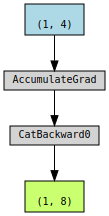

In [ ]:
make_dot(d)

In [ ]:
# Write a simple pytorch model to make a input matrix all zeros

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


#  Create a random input matrix
input = torch.randn(100, 100)
target = torch.zeros(100, 100)

net(input)

Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
)


tensor([[-0.0982, -0.0146, -0.0158,  ..., -0.0057,  0.1584, -0.0914],
        [-0.1816,  0.1002, -0.0153,  ...,  0.0331,  0.0191, -0.1980],
        [-0.0030,  0.0337, -0.0480,  ...,  0.1086, -0.0089, -0.1005],
        ...,
        [-0.0250, -0.0209, -0.0705,  ..., -0.0090, -0.0091, -0.1790],
        [ 0.0072,  0.0159,  0.0318,  ...,  0.0188,  0.0178, -0.2131],
        [-0.0755,  0.1134, -0.0460,  ..., -0.0161,  0.0822, -0.2433]],
       grad_fn=<AddmmBackward0>)

In [ ]:
# Train the network
for epoch in range(10000):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(input)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 100 == 0:
        print("Epoch: %d | Loss: %.3f" % (epoch + 1, loss.item()))

Epoch: 1 | Loss: 0.001
Epoch: 101 | Loss: 0.001
Epoch: 201 | Loss: 0.001
Epoch: 301 | Loss: 0.001
Epoch: 401 | Loss: 0.001
Epoch: 501 | Loss: 0.001
Epoch: 601 | Loss: 0.001
Epoch: 701 | Loss: 0.001
Epoch: 801 | Loss: 0.001
Epoch: 901 | Loss: 0.001
Epoch: 1001 | Loss: 0.001
Epoch: 1101 | Loss: 0.001
Epoch: 1201 | Loss: 0.000
Epoch: 1301 | Loss: 0.000
Epoch: 1401 | Loss: 0.000
Epoch: 1501 | Loss: 0.000
Epoch: 1601 | Loss: 0.000
Epoch: 1701 | Loss: 0.000
Epoch: 1801 | Loss: 0.000
Epoch: 1901 | Loss: 0.000
Epoch: 2001 | Loss: 0.000
Epoch: 2101 | Loss: 0.000
Epoch: 2201 | Loss: 0.000
Epoch: 2301 | Loss: 0.000
Epoch: 2401 | Loss: 0.000
Epoch: 2501 | Loss: 0.000
Epoch: 2601 | Loss: 0.000
Epoch: 2701 | Loss: 0.000
Epoch: 2801 | Loss: 0.000
Epoch: 2901 | Loss: 0.000
Epoch: 3001 | Loss: 0.000
Epoch: 3101 | Loss: 0.000
Epoch: 3201 | Loss: 0.000
Epoch: 3301 | Loss: 0.000
Epoch: 3401 | Loss: 0.000
Epoch: 3501 | Loss: 0.000
Epoch: 3601 | Loss: 0.000
Epoch: 3701 | Loss: 0.000
Epoch: 3801 | Loss: 0.00

In [ ]:
net(input)

tensor([[-0.0070, -0.0021, -0.0031,  ...,  0.0001,  0.0132,  0.0047],
        [-0.0069, -0.0009, -0.0029,  ..., -0.0044,  0.0041, -0.0019],
        [ 0.0075,  0.0034,  0.0045,  ..., -0.0075, -0.0102, -0.0078],
        ...,
        [ 0.0001,  0.0026,  0.0006,  ..., -0.0040, -0.0030, -0.0050],
        [ 0.0003, -0.0051,  0.0034,  ...,  0.0105, -0.0019,  0.0015],
        [ 0.0021,  0.0032,  0.0034,  ..., -0.0020, -0.0100, -0.0043]],
       grad_fn=<AddmmBackward0>)

In [ ]:
target

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
torch.cat((net.fc1.weight, torch.tensor([[1.0, 2.0, 3.0]])), dim=1)

RuntimeError: ignored

In [ ]:
net.fc1.state_dict()

OrderedDict([('weight',
              tensor([[-0.0124, -0.0109, -0.0944,  ...,  0.0164,  0.0634,  0.0776],
                      [ 0.0801,  0.0847, -0.0811,  ...,  0.0136, -0.0262,  0.0160],
                      [-0.0189,  0.0848, -0.0706,  ...,  0.0347,  0.0782, -0.0650],
                      ...,
                      [ 0.0604, -0.0892,  0.0745,  ..., -0.0946,  0.0488,  0.0061],
                      [-0.0851, -0.0160, -0.0677,  ...,  0.0094,  0.0220,  0.0465],
                      [ 0.0612, -0.0575, -0.0130,  ...,  0.0534,  0.0383,  0.0638]])),
             ('bias',
              tensor([ 0.0093,  0.0511,  0.0558,  0.0614, -0.0736, -0.0620,  0.0701,  0.0701,
                       0.0848,  0.0694,  0.0145,  0.0199, -0.0879, -0.0818, -0.0569,  0.0355,
                       0.0605,  0.0178,  0.0664, -0.0504, -0.0238, -0.0877,  0.0469,  0.0038,
                      -0.0521, -0.0598,  0.0445,  0.0132,  0.0595, -0.0747,  0.0566,  0.0555,
                      -0.0422, -0.0658,  0.0

In [ ]:
type(net.fc1)

torch.nn.modules.linear.Linear

In [ ]:
e1 = nn.Linear(3, 2)
e2 = nn

Linear(in_features=3, out_features=2, bias=True)

In [ ]:
l.

SyntaxError: ignored

In [ ]:
n, d, m = 3, 5, 7
embedding = nn.Embedding(n, d, padding_idx=1)
embedding

Embedding(3, 5, padding_idx=1)

In [ ]:
for i in embedding.weight:
    print(torch.cat((i, torch.tensor([1, 2, 3])), dim=-1))

tensor([ 1.1540,  1.5319, -0.7825,  1.1834,  0.5428,  1.0000,  2.0000,  3.0000],
       grad_fn=<CatBackward0>)
tensor([0., 0., 0., 0., 0., 1., 2., 3.], grad_fn=<CatBackward0>)
tensor([-0.8522, -0.0847, -0.8927,  0.5998, -0.9139,  1.0000,  2.0000,  3.0000],
       grad_fn=<CatBackward0>)


In [ ]:
embedding.weight  # [0] = torch.cat((embedding.weight[0], torch.tensor([1,2,3])), dim=-1)

Parameter containing:
tensor([[ 1.1540,  1.5319, -0.7825,  1.1834,  0.5428],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8522, -0.0847, -0.8927,  0.5998, -0.9139]], requires_grad=True)

In [ ]:
e1 = nn.Embedding(3, 4)
e2 = nn.Embedding(3, 4)
torch.cat((e1, e2))

TypeError: ignored

In [ ]:
e1.weight[0][0]  # .requires_grad = False

tensor(-0.9906)

In [ ]:
for i in e1.weight:
    i[0] = 10
    i[0].requires_grad = False
e1.weight

Parameter containing:
tensor([[ 1.0000e+01, -2.4244e-01, -2.4647e-01,  1.2489e-01],
        [ 1.0000e+01,  1.2004e+00, -1.1638e+00,  3.5658e-01],
        [ 1.0000e+01,  4.4339e-01, -1.1785e+00, -4.4250e-03]])

In [ ]:
1.0000e01

10.0

In [ ]:
e2.weight.requires_grad

True

In [ ]:
n = pl.DataFrame({"col0": [1, 2, 3], "col1": ["a", "b", "c"]})
n

col0,col1
i64,str
1,"""a"""
2,"""b"""
3,"""c"""


In [ ]:
df = pl.DataFrame({"col0": [1, 2, 3], "col1": ["a", "b", "c"]})
df.with_columns(
    [
        pl.col("col1").str.to_uppercase().alias("upper"),
        (pl.col("col1") + "_new").alias("add_new"),
    ]
)

col0,col1,upper,add_new
i64,str,str,str
1,"""a""","""A""","""a_new"""
2,"""b""","""B""","""b_new"""
3,"""c""","""C""","""c_new"""


In [ ]:
DO

Do two headed attention, between time steps and within time steps.

## Embeddings

In [ ]:
nn.Embedding

torch.nn.modules.sparse.Embedding

In [ ]:
nn.F

AttributeError: ignored

In [ ]:
from torch.functional import F

In [ ]:
F.embedding()

In [ ]:
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/sparse.py

In [ ]:
class FreezableEmbedding(nn.Module):
    """    Embedding module that can be frozen.

    All frozen tokens MUST be at the start of the vocab.
    """
    def __init__(self, num_embeddings, embedding_dim, n_frozen=0):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        self.n_unfrozen = num_embeddings - n_frozen

        self.n_frozen = n_frozen

        self.frozen_weight = nn.Parameter(torch.randn(self.n_unfrozen, embedding_dim))

        self.unfrozen_weight = nn.Parameter(torch.randn(self.n_frozen, embedding_dim))
        self.unfrozen_weight.requires_grad = False

        self.unfrozen_weight = nn.Parameter(torch.randn(self.n_unfrozen, embedding_dim))

        self.weight = torch.cat([self.frozen_weight, self.unfrozen_weight], dim=0)


    def 



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py

/usr/local/lib/python3.8/dist-packages/torch/_C/_VariableFunctions.pyi